In [1]:
import pytorch_lightning as pl
from src import Model, DataModule

In [2]:
size = 256
config = {
    # optimization
    'lr': 3e-4,
    'optimizer': 'Adam',
    'batch_size': 128,
    # data
    'extra_data': 1,
    'subset': 0.1,
    'num_workers': 0,
    'pin_memory': True,
    # model
    'backbone': 'seresnext50_32x4d',
    'pretrained': True,
    'unfreeze': 0,
    # data augmentation
    'size': size,
    'train_trans': {
        'RandomCrop': {
            'height': size, 
            'width': size
        },
        'HorizontalFlip': {},
        'VerticalFlip': {},
        'Normalize': {}
    },
    'val_trans': {
        'CenterCrop': {
            'height': size, 
            'width': size
        },
        'Normalize': {}
    },
    # training params
    'precision': 16,
    'max_epochs': 50,
    'val_batches': 5,
    'es_start_from': 0
}

In [3]:
dm = DataModule(
    file = 'data_extra' if config['extra_data'] else 'data_old', 
    **config
)

model = Model(config)

In [ ]:
trainer = pl.Trainer(
    gpus=1,
    precision=config['precision'],
    limit_val_batches=config['val_batches'],
    auto_scale_batch_size='binsearch'
)

trainer.tune(model, dm)

In [4]:
model.hparams.batch_size = 250
model.hparams

"backbone":      seresnext50_32x4d
"batch_size":    250
"es_start_from": 0
"extra_data":    1
"lr":            0.0003
"max_epochs":    50
"num_workers":   0
"optimizer":     Adam
"pin_memory":    True
"precision":     16
"pretrained":    True
"size":          256
"subset":        0.1
"train_trans":   {'RandomCrop': {'height': 256, 'width': 256}, 'HorizontalFlip': {}, 'VerticalFlip': {}, 'Normalize': {}}
"unfreeze":      0
"val_batches":   5
"val_trans":     {'CenterCrop': {'height': 256, 'width': 256}, 'Normalize': {}}

In [5]:
trainer = pl.Trainer(
    gpus=1,
    precision=config['precision'],
    limit_val_batches=config['val_batches'],
    auto_lr_find=True
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


In [6]:
lr_finder = trainer.tuner.lr_find(model, dm)

Training samples:  21642
Validation samples:  5411
Training only on 2165 samples



  | Name     | Type           | Params
--------------------------------------------
0 | backbone | FeatureListNet | 25.5 M
1 | head     | Sequential     | 10.2 K
--------------------------------------------
25.5 M    Trainable params
0         Non-trainable params
25.5 M    Total params


C:\Users\sensio\miniconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


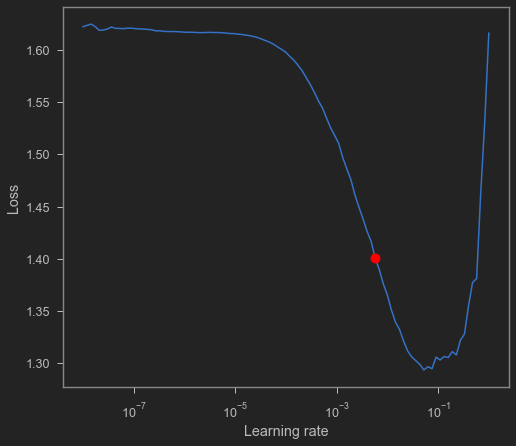

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [10]:
new_lr = lr_finder.suggestion()
model.hparams.lr = new_lr
model.hparams.lr

0.005754399373371567

In [9]:
#trainer.fit(model, dm)